# Training Testing on Original Data (All views stacked together)

### Loading Required Libraries

In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Conv3D, MaxPooling3D
import tensorflow as tf

from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau

### Useful Functions

In [90]:
def callbacks(class_type):
    csv_logger = CSVLogger("/notebooks/Results/model_history_log_" + class_type + ".csv", append=True)
    logfilepath = "Models/setting_model2.csv"
    checkpoint_path = "Models/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    reduce_lr_rate=0.5
    earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=12, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=reduce_lr_rate, patience=2,
                                  cooldown=0, min_lr=0.00001, verbose=0)
    callbacks_list = [earlyStopping, reduce_lr, csv_logger]
    return callbacks_list

In [91]:
def create_model(x, y, inChannel, z):
    model = Sequential()
    model.add(Conv3D(filters=32, kernel_size=3, activation="relu",input_shape=(x, y, inChannel, z)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Conv3D(filters=64, kernel_size=1, activation="relu",input_shape=(x, y, inChannel, z)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.05))
    model.add(MaxPooling3D(pool_size=2,padding='same'))
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    return model

## Slices Data Loading

### Train and Valid Axial, Coronal, Saggital

In [92]:
x_input_axial = np.load('/notebooks/training_set_axial.npy')
x_input_cor = np.load('/notebooks/training_set_coronal.npy')
x_input_sag = np.load('/notebooks/training_set_sagittal.npy')

train_data = np.stack((x_input_axial, x_input_cor, x_input_sag), axis=-1)

del x_input_axial
del x_input_cor
del x_input_sag

val_input_axial = np.load('/notebooks/valid_set_axial.npy')
val_input_cor = np.load('/notebooks/valid_set_coronal.npy')
val_input_sag = np.load('/notebooks/valid_set_sagittal.npy')

test_data = np.stack((val_input_axial, val_input_cor, val_input_sag), axis=-1)

del val_input_axial
del val_input_cor
del val_input_sag


### 1. Abnormal Class

##### Label Loading and converting to one-hot encoding

In [93]:
class_type = 'abnormal'
train_labs = pd.read_csv('/notebooks/train-abnormal.csv')
valid_labs = pd.read_csv('/notebooks/valid-abnormal.csv')

train_1_hot_labs = np.zeros((len(train_labs.Label), 2))
val_1_hot_labs = np.zeros((len(valid_labs.Label), 2))

ctr = 0
for label in train_labs.Label:
    if label == 0:
        train_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        train_1_hot_labs[ctr, 1] = 1
    ctr+=1

ctr = 0
for label in valid_labs.Label:
    if label == 0:
        val_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        val_1_hot_labs[ctr, 1] = 1
    ctr+=1

#### Model Training and Testing

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_53 (Conv3D)          (None, 254, 254, 1, 32)   2624      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 254, 254, 1, 32)   0         
                                                                 
 conv3d_54 (Conv3D)          (None, 254, 254, 1, 64)   2112      
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                                 
 batch_normalization_25 (Bat  (None, 254, 254, 1, 64)  256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                     

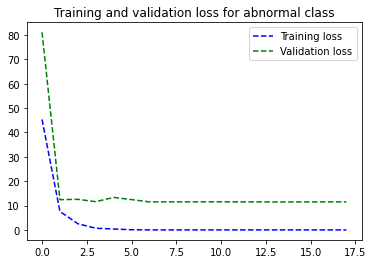

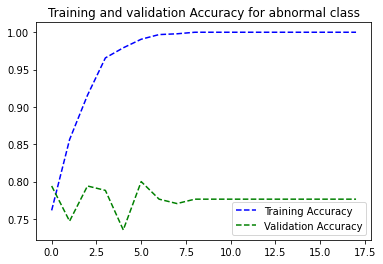

In [94]:
batch_size_ = 8
epochs_ = 50
inChannel = train_data.shape[3]
x, y, z =  train_data.shape[1], train_data.shape[2], train_data.shape[4]

model = create_model(x, y, inChannel, z)
print(model.summary())

callbacks_list = callbacks(class_type)
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model_train = model.fit(train_data, train_1_hot_labs,
                    epochs = epochs_, batch_size = batch_size_,
                    verbose=1, validation_split=0.15, callbacks=callbacks_list)

test_eval=model.evaluate(test_data, val_1_hot_labs, verbose=0)
print("Test Accuracy: ",test_eval[1])

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(300)
plt.figure()
plt.plot(loss, 'b--', label='Training loss')
plt.plot(val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss for ' + class_type + ' class')
plt.legend()

plt.show()

acc = model_train.history['accuracy']
val_acc = model_train.history['val_accuracy']
epochs = range(300)
plt.figure()
plt.plot(acc, 'b--', label='Training Accuracy')
plt.plot(val_acc, 'g--', label='Validation Accuracy')
plt.title('Training and validation Accuracy for ' + class_type + ' class')
plt.legend()

plt.show()

### 2. ACL Class

##### Label Loading and converting to one-hot encoding

In [95]:
class_type = 'acl'
train_labs = pd.read_csv('/notebooks/train-acl.csv')
valid_labs = pd.read_csv('/notebooks/valid-acl.csv')

train_1_hot_labs = np.zeros((len(train_labs.Label), 2))
val_1_hot_labs = np.zeros((len(valid_labs.Label), 2))

ctr = 0
for label in train_labs.Label:
    if label == 0:
        train_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        train_1_hot_labs[ctr, 1] = 1
    ctr+=1

ctr = 0
for label in valid_labs.Label:
    if label == 0:
        val_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        val_1_hot_labs[ctr, 1] = 1
    ctr+=1

#### Model Training and Testing

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_55 (Conv3D)          (None, 254, 254, 1, 32)   2624      
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 254, 254, 1, 32)   0         
                                                                 
 conv3d_56 (Conv3D)          (None, 254, 254, 1, 64)   2112      
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                                 
 batch_normalization_26 (Bat  (None, 254, 254, 1, 64)  256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                     

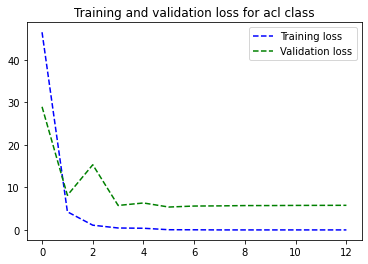

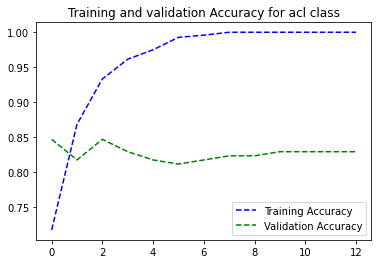

In [96]:
batch_size_ = 16
epochs_ = 100
inChannel = train_data.shape[3]
x, y, z =  train_data.shape[1], train_data.shape[2], train_data.shape[4]

model = create_model(x, y, inChannel, z)
print(model.summary())

callbacks_list = callbacks(class_type)
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model_train = model.fit(train_data, train_1_hot_labs,
                    epochs = epochs_, batch_size = batch_size_,
                    verbose=1, validation_split=0.15, callbacks=callbacks_list)

test_eval=model.evaluate(test_data, val_1_hot_labs, verbose=0)
print("Test Accuracy: ",test_eval[1])

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(300)
plt.figure()
plt.plot(loss, 'b--', label='Training loss')
plt.plot(val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss for ' + class_type + ' class')
plt.legend()

plt.show()

acc = model_train.history['accuracy']
val_acc = model_train.history['val_accuracy']
epochs = range(300)
plt.figure()
plt.plot(acc, 'b--', label='Training Accuracy')
plt.plot(val_acc, 'g--', label='Validation Accuracy')
plt.title('Training and validation Accuracy for ' + class_type + ' class')
plt.legend()

plt.show()

### 3. Meniscus Class

##### Label Loading and converting to one-hot encoding

In [97]:
class_type = 'meniscus'
train_labs = pd.read_csv('/notebooks/train-meniscus.csv')
valid_labs = pd.read_csv('/notebooks/valid-meniscus.csv')

train_1_hot_labs = np.zeros((len(train_labs.Label), 2))
val_1_hot_labs = np.zeros((len(valid_labs.Label), 2))

ctr = 0
for label in train_labs.Label:
    if label == 0:
        train_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        train_1_hot_labs[ctr, 1] = 1
    ctr+=1

ctr = 0
for label in valid_labs.Label:
    if label == 0:
        val_1_hot_labs[ctr, 0] = 1
    elif label == 1:
        val_1_hot_labs[ctr, 1] = 1
    ctr+=1

#### Model Training and Testin

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_59 (Conv3D)          (None, 254, 254, 1, 32)   2624      
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 254, 254, 1, 32)   0         
                                                                 
 conv3d_60 (Conv3D)          (None, 254, 254, 1, 64)   2112      
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                                 
 batch_normalization_28 (Bat  (None, 254, 254, 1, 64)  256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 254, 254, 1, 64)   0         
                                                     

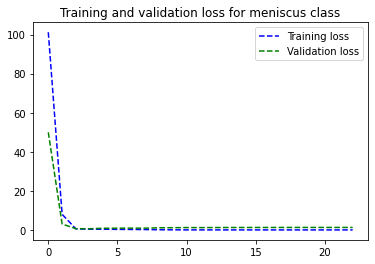

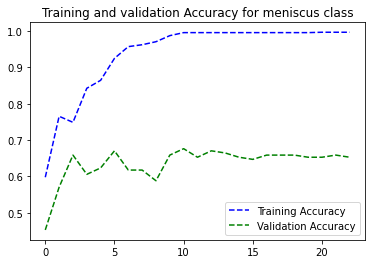

In [99]:
batch_size_ = 16
epochs_ = 100
inChannel = train_data.shape[3]
x, y, z =  train_data.shape[1], train_data.shape[2], train_data.shape[4]

model = create_model(x, y, inChannel, z)
print(model.summary())

callbacks_list = callbacks(class_type)
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC() ])
model_train = model.fit(train_data, train_1_hot_labs,
                    epochs = epochs_, batch_size = batch_size_,
                    verbose=1, validation_split=0.15, callbacks=callbacks_list)

test_eval=model.evaluate(test_data, val_1_hot_labs, verbose=0)
print("Test Accuracy: ",test_eval[1])

loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(300)
plt.figure()
plt.plot(loss, 'b--', label='Training loss')
plt.plot(val_loss, 'g--', label='Validation loss')
plt.title('Training and validation loss for ' + class_type + ' class')
plt.legend()

plt.show()

acc = model_train.history['accuracy']
val_acc = model_train.history['val_accuracy']
epochs = range(300)
plt.figure()
plt.plot(acc, 'b--', label='Training Accuracy')
plt.plot(val_acc, 'g--', label='Validation Accuracy')
plt.title('Training and validation Accuracy for ' + class_type + ' class')
plt.legend()

plt.show()